# Overview
Variant Association Tools [VAT, Wang et al (2014)] [1] was developed to perform quality control and association analysis of sequence data. It can also be used to analyze genotype data, e.g. exome chip data and imputed data. The software incorporates many rare variant association methods which include but not limited to Combined Multivariate Collapsing (CMC) [2], Burden of Rare Variants (BRV) [3], Weighted Sum Statistic (WSS) [4], Kernel Based Adaptive Cluster (KBAC) [5], Variable Threshold (VT) [6] and Sequence Kernel Association Test (SKAT) [7].
VAT inherits the intuitive command-line interface of Variant Tools (VTools) [8] with re-design and implementation of its infrastructure to accommodate the scale of dataset generated from current sequencing efforts on large populations. Features of VAT are implemented into VTools subcommand system.

## Resources

Basic concepts to handle sequence data using `vtools` can be found at:

http://varianttools.sourceforge.net/Main/Concepts

VAT Software documentation:

http://varianttools.sourceforge.net/Main/Documentation

## Genotype data

Exome genotype data was downloaded from the 1000 Genomes pilot data July 2010 release for both the CEU and YRI populations. Only the autosomes are contained in the datasets accompanying this exercise.
The data sets (`CEU.exon.2010_03.genotypes.vcf.gz, YRI.exon.2010_03.genotypes.vcf.gz`) are available from:
ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/release/2010_07/exon/snps

## Phenotype data
To demonstrate the association analysis, we simulated a quantitative trait phenotype (BMI). Please note that these phenotypes are NOT from the 1000 genome project.

### Computation resources
Due to the nature of next-generation sequencing data, a reasonably powerful machine with high speed internet connection is needed to use this tool for real-world applications. For this reason, in this tutorial we will use a small demo dataset to demonstrate association analysis.

# Part I: Data Quality Control, Annotation and Variant/sample Selection

## Getting started
Please navigate to the exercise data directory, and check the available subcommands by typing:

In [1]:
vtools -h

usage: vtools [-h] [--version]
              {init,import,phenotype,show,liftover,use,update,select,exclude,compare,output,export,remove,associate,admin,execute,simulate}
              ...

A variant calling, processing, annotation and analysis tool for next-
generation sequencing studies.

optional arguments:
  -h, --help            show this help message and exit
  --version             show program's version number and exit

subcommands:
  {init,import,phenotype,show,liftover,use,update,select,exclude,compare,output,export,remove,associate,admin,execute,simulate}
    init                Create a new project, or a subproject from an existing
                        parent project, or merge several existing projects
                        into one
    import              Import variants and related sample genotype from files
                        in specified formats
    phenotype           Manage sample phenotypes
    show                Display content of a project
    liftover  

Subcommand system is used for various data manipulation tasks (to check details of each subcommand use `vtools <name of subcommand> -h`). This tutorial is mission oriented and focuses on a subset of the commands that are relevant to variant-phenotype association analysis, rather than introducing them systematically. For additional functionality, please refer to documentation and tutorials online.

### Initialize a project

In [2]:
vtools init VATDemo

INFO: variant tools 3.1.3 : Copyright (c) 2011 - 2016 Bo Peng
INFO: Please visit https://github.com/vatlab/varianttools for more information.
INFO: Creating a new project VATDemo


Command `vtools init` creates a new project in the current directory. A directory can only have one project. After a project is created, subsequent `vtools` calls will automatically load the project in the current directory. Working from outside of a project directory is not allowed.

### Import variant and genotype data


Import all vcf files under the current directory:


In [3]:
vtools import *.vcf.gz --var_info DP filter --geno_info DP_geno --build hg18 -j1

INFO: Importing variants from CEU.exon.2010_03.genotypes.vcf.gz (1/2)
CEU.exon.2010_03.genotypes.vcf.gz: 100% [============] 4,306 17.8K/s in 00:00:00
INFO: 3,489 new variants (3,489 SNVs) from 3,500 lines are imported.
Importing genotypes: 100% [===========================] 3,489 6.8K/s in 00:00:00
INFO: Importing variants from YRI.exon.2010_03.genotypes.vcf.gz (2/2)
YRI.exon.2010_03.genotypes.vcf.gz: 100% [============] 5,967 17.5K/s in 00:00:00
INFO: 3,498 new variants (5,175 SNVs) from 5,186 lines are imported.
Importing genotypes: 100% [===========================] 6,987 9.3K/s in 00:00:00


Command `vtools import` imports variants, sample genotypes and related information fields. The imported variants are saved to the master variant table for the project, along with their information fields.

The command above imports two vcf files sequentially into an empty `vtools` project. The second `INFO` message in the screen output shows that 3,489 variant sites are imported from the first vcf file, where 3,489 new means that all of them are new because prior to importing the first vcf the project was empty so there was 0 site. The fourth `INFO` message tells that 5,175 variant sites are imported from the second vcf file, but only 3,498 of them are new (which are not seen in the existing 3,489) because prior to importing the second vcf there were already 3,489 existing variant sites from first vcf. 

Thus, 5,175 - 3,498 = 1,677 variant sites are overlapped sites between first and second vcfs. The last `INFO` message summarizes that the sum of variant sites contained in both vcfs is 8,664 = 3,489 + 5,175, where there are 6,987 variant sites after merging variants from both vcfs.

More details about `vtools import` command can be found at:

http://varianttools.sourceforge.net/Vtools/Import

Since the input VCF file uses hg18 as the reference genome while most modern annotation data sources are hg19-based, we need to "liftover" our project using hg19 in order to use various annotation sources in the analysis. Vtools provides a command which is based on the tool of USCS `liftOver` to map the variants from existing reference genome to an alternative build. More details about `vtools liftover` command can be found at:

http://varianttools.sourceforge.net/Vtools/Liftover

In [4]:
vtools liftover hg19 --flip

INFO: Downloading liftOver tool from UCSC
liftOver: 100% [===============================] 28,777,496.0 5.6M/s in 00:00:05
INFO: Downloading liftOver chain file from UCSC
hg18ToHg19.over.chain.gz: 100% [================] 140,346.0 158.2K/s in 00:00:00
INFO: Exporting variants in BED format
Exporting variants: 100% [==========================] 6,987 199.9K/s in 00:00:00
INFO: Running UCSC liftOver tool
INFO: Flipping primary and alternative reference genome
Updating table variant: 100% [=======================] 6,987 20.0K/s in 00:00:00


### Import phenotype data

The aim of the association test is to find variants that modulate the phenotype BMI. We simulated BMI values for each of the individuals. The phenotype file must be in plain text format with sample names matching the sample IDs in the vcf file(s):

In [5]:
%preview phenotypes.csv -n -l 10

> phenotypes.csv (5.0 KiB):

,sample_name,panel,SEX,BMI
0,NA06984,ILLUMINA,1,36.353
1,NA06985,NaN,2,21.415
2,NA06986,ABI_SOLID+ILLUMINA,1,26.898
3,NA06989,ILLUMINA,2,25.015
4,NA06994,ABI_SOLID+ILLUMINA,1,23.858
5,NA07000,ABI_SOLID+ILLUMINA,2,36.226
6,NA07037,ILLUMINA,1,32.513
7,NA07048,ILLUMINA,2,17.570
8,NA07051,ILLUMINA,1,37.142
9,NA07346,NaN,2,30.978


The phenotype file includes information for every individual, the sample name, sequencing panel, sex and BMI. To import the phenotype data:

In [6]:
vtools phenotype --from_file phenotypes.csv --delimiter ","

INFO: Adding phenotype panel of type VARCHAR(24)
INFO: Adding phenotype SEX of type INT
INFO: Adding phenotype BMI of type FLOAT
INFO: 3 field (3 new, 0 existing) phenotypes of 202 samples are updated.


Unlike `vtools import`, this command imports/adds properties to samples rather than to variants. More details about `vtools phenotype` command can be found at:

http://varianttools.sourceforge.net/Vtools/Phenotype

### View imported data
Summary information for the project can be viewed anytime using the command `vtools show`, which displays various project and system information. More details about `vtools show` can be found at:

http://varianttools.sourceforge.net/Vtools/Show

Some useful data summary commands are:

In [7]:
vtools show project

Project name:                VATDemo
Created on:                  Mon Jan 25 20:45:27 2021
Primary reference genome:    hg19
Secondary reference genome:  hg18
Storage method:              hdf5
Runtime options:             verbosity=1, shared_resource=/home/jovyan/.variant_tools, local_resource=/home/jovyan/.variant_tools
Variant tables:              variant
Annotation databases:        



In [8]:
vtools show tables

table      #variants     date message
variant        6,987    Jan25 Master variant table


In [9]:
vtools show table variant

Name:                   variant
Description:            Master variant table
Creation date:          Jan25
Command:
Fields:                 variant_id, bin, chr, pos, ref, alt, DP, filter,
                        alt_bin, alt_chr, alt_pos
Number of variants:     6987


In [10]:
vtools show fields

variant.chr (char)      Chromosome name (VARCHAR)
variant.pos (int)       Position (INT, 1-based)
variant.ref (char)      Reference allele (VARCHAR, - for missing allele of an
                        insertion)
variant.alt (char)      Alternative allele (VARCHAR, - for missing allele of an
                        deletion)
variant.DP (int)
variant.filter (char)
variant.alt_chr (char)
variant.alt_pos (int)


## Overview of variant and genotype data

### Total number of variants

The number of imported variants may be greater than number of lines in the vcf file, because when a variant has two alternative alleles (e.g. A->T/C) it is treated as two separate variants.

In [11]:
vtools select variant --count

Counting variants: 4 311.4/s in 00:00:00                                        
6987


There are 6987 variants in our toy data-set.

`vtools select table condition action` selects from a variant table `table` a subset of variants satisfying a specified `condition`, and perform an `action` of

- creating a new variant table if `--to_table` is specified.
- counting the number of variants if `--count` is specified.
- outputting selected variants if `--output` is specified.

The `condition` should be a SQL expression using one or more fields in a project (displayed in `vtools show` fields). If the condition argument is unspecified, then all variants in the table will be selected. An optional condition `--samples [condition]` can also be used to limit selected variants to specific samples. More details about `vtools select` command can be found at:

http://varianttools.sourceforge.net/Vtools/Select

### Genotype Summary

The command `vtools show genotypes` displays the number of genotypes for each sample and names of the available genotype information fields for each sample, e.g. GT - genotype; DP geno - genotype read depth. Such information is useful for the calculation of summary statistics of genotypes (e.g. depth of coverage).

In [12]:
vtools show genotypes > genotype_summary.txt

In [13]:
%preview genotype_summary.txt -n -l 10

> genotype_summary.txt (11.5 KiB):

203 lines (10 displayed, see --limit)

sample_name	filename                 	num_genotypes	sample_genotype_fields
NA06984    	CEU.exon...notypes.vcf.gz	3162         	DP,GT
NA06985    	CEU.exon...notypes.vcf.gz	3144         	DP,GT
NA06986    	CEU.exon...notypes.vcf.gz	3437         	DP,GT
NA06989    	CEU.exon...notypes.vcf.gz	3130         	DP,GT
NA06994    	CEU.exon...notypes.vcf.gz	3002         	DP,GT
NA07000    	CEU.exon...notypes.vcf.gz	3388         	DP,GT
NA07037    	CEU.exon...notypes.vcf.gz	3374         	DP,GT
NA07048    	CEU.exon...notypes.vcf.gz	3373         	DP,GT
NA07051    	CEU.exon...notypes.vcf.gz	3451         	DP,GT

### Variant Quality Overview

The following command calculates summary statistics on the variant site depth of coverage (DP). Below is the command to calculate depth of coverage information for all variant sites.

In [14]:
vtools output variant "max(DP)" "min(DP)" "avg(DP)" "stdev(DP)" "lower_quartile(DP)" "upper_quartile(DP)" --header

max_DP_	min_DP_	avg_DP_           	stdev_DP_         	lower_quartile_DP_	upper_quartile_DP_
25490  	13     	6815.7702876771145	3434.2804009099777	4301              	9143


In the test data, the maximum DP for variant sites is 25490, minimum DP 13, average DP about 6815, standard deviation of DP about 3434, lower quartile of DP 4301 and upper quartile of DP 9143.

The same syntax can be applied to other variant information or annotation information fields. The command `vtools output <name of variant table>` outputs properties of variants in a specified variant table. The properties include fields from annotation databases and variant tables, basically fields outputted from command `vtools show fields`, and SQL-supported functions and expressions. There are several freely available SQL resources on the web to learn more about SQL functions and expressions.

It is also possible to view variant level summary statistic for variants satisfying certain filtering criteria using `vtools select <name of variant table>` command, for example to count only variants having passed all quality filters:

In [15]:
vtools select variant "filter='PASS'" --count

Counting variants: 5 352.6/s in 00:00:00                                        
6987


All 6987 variants have passed the quality filters. To combine variant filtering and summary statistics:

In [16]:
vtools select variant "filter='PASS'" -o "max(DP)" "min(DP)" "avg(DP)" "stdev(DP)" "lower_quartile(DP)" "upper_quartile(DP)" --header

max_DP_	min_DP_	avg_DP_           	stdev_DP_         	lower_quartile_DP_	upper_quartile_DP_
25490  	13     	6815.7702876771145	3434.2804009099777	4301              	9143


The output information of command above will be the same as the previous vtools output command, since all variants have passed quality filter.

## Data exploration

### Variant level summaries

The command below will calculate:
- `total`: Total number of genotypes (GT) for a variant
- `num`: Total number of alternative alleles across all samples
- `het`: Total number of heterozygote genotypes 1/0
- `hom`: Total number of homozygote genotypes 1/1
- `other`: Total number of double-homozygotes 1/2
- `min/max/meanDP`: Summaries for depth of coverage and genotype quality across samples
- `maf`: Minor allele frequency
- Add calculated variant level statistics to `fields`, which can be shown by commands `vtools show fields` and `vtools show table variant`

In [17]:
vtools update variant --from_stat 'total=#(GT)' 'num=#(alt)' 'het=#(het)' 'hom=#(hom)' 'other=#(other)' 'minDP=min(DP_geno)' 'maxDP=max(DP_geno)' 'meanDP=avg(DP_geno)' 'maf=maf()'

INFO: Reading genotype info for processing....
INFO: Adding variant info field num with type INT
INFO: Adding variant info field hom with type INT
INFO: Adding variant info field het with type INT
INFO: Adding variant info field other with type INT
INFO: Adding variant info field total with type INT
INFO: Adding variant info field maf with type FLOAT
INFO: Adding variant info field minDP with type INT
INFO: Adding variant info field maxDP with type INT
INFO: Adding variant info field meanDP with type FLOAT
Updating variant: 100% [=============================] 6,987 16.4K/s in 00:00:00


In [18]:
vtools show fields

variant.chr (char)      Chromosome name (VARCHAR)
variant.pos (int)       Position (INT, 1-based)
variant.ref (char)      Reference allele (VARCHAR, - for missing allele of an
                        insertion)
variant.alt (char)      Alternative allele (VARCHAR, - for missing allele of an
                        deletion)
variant.DP (int)
variant.filter (char)
variant.alt_chr (char)
variant.alt_pos (int)
variant.num (int)       Created from stat "#(alt)"  with type INT on Jan25
variant.hom (int)       Created from stat "#(hom)"  with type INT on Jan25
variant.het (int)       Created from stat "#(het)"  with type INT on Jan25
variant.other (int)     Created from stat "#(other)"  with type INT on Jan25
variant.total (int)     Created from stat "#(GT)"  with type INT on Jan25
variant.maf (float)     Created from stat "maf()"  with type FLOAT on Jan25
variant.minDP (int)     Created from stat "min(DP_geno)"  with type INT on Jan25
variant.maxDP (int)     Created from stat "max(DP_geno)"  

In [19]:
vtools show table variant

Name:                   variant
Description:            Master variant table
Creation date:          Jan25
Command:
Fields:                 variant_id, bin, chr, pos, ref, alt, DP, filter,
                        alt_bin, alt_chr, alt_pos, num, hom, het, other, total,
                        maf, minDP, maxDP, meanDP
Number of variants:     6987


Command `vtools update` updates variant info fields (and to a lesser extend genotype info fields) by adding more fields or updating values at existing fields. It does not add any new variants or genotypes, and does not change existing variants, samples, or genotypes. Using three parameters `--from_file`, `--from_stat`, and `--set`, variant information fields could be updated from external file, sample genotypes, and existing fields. More details about vtools update command can be found at

http://varianttools.sourceforge.net/Vtools/Update

### Summaries for different genotype depth (GD) and genotype quality (GQ) filters

The `--genotypes CONDITION` option restricts calculation to genotypes satisfying a given condition. Later we will remove individual genotypes by `DP_geno` filters. The command below will calculate summary statistics genotypes of all samples per variant site. It can assist us in determining filtering criteria for genotype call quality.

In [20]:
vtools update variant --from_stat 'totalGD10=#(GT)' 'numGD10=#(alt)' 'hetGD10=#(het)' 'homGD10=#(hom)' 'otherGD10=#(other)' 'mafGD10=maf()' --genotypes "DP_geno > 10"

INFO: Reading genotype info for processing....
INFO: Adding variant info field numGD10 with type INT
INFO: Adding variant info field homGD10 with type INT
INFO: Adding variant info field hetGD10 with type INT
INFO: Adding variant info field otherGD10 with type INT
INFO: Adding variant info field totalGD10 with type INT
INFO: Adding variant info field mafGD10 with type FLOAT
Updating variant: 100% [=============================] 6,987 21.4K/s in 00:00:00


In [21]:
vtools show fields

variant.chr (char)      Chromosome name (VARCHAR)
variant.pos (int)       Position (INT, 1-based)
variant.ref (char)      Reference allele (VARCHAR, - for missing allele of an
                        insertion)
variant.alt (char)      Alternative allele (VARCHAR, - for missing allele of an
                        deletion)
variant.DP (int)
variant.filter (char)
variant.alt_chr (char)
variant.alt_pos (int)
variant.num (int)       Created from stat "#(alt)"  with type INT on Jan25
variant.hom (int)       Created from stat "#(hom)"  with type INT on Jan25
variant.het (int)       Created from stat "#(het)"  with type INT on Jan25
variant.other (int)     Created from stat "#(other)"  with type INT on Jan25
variant.total (int)     Created from stat "#(GT)"  with type INT on Jan25
variant.maf (float)     Created from stat "maf()"  with type FLOAT on Jan25
variant.minDP (int)     Created from stat "min(DP_geno)"  with type INT on Jan25
variant.maxDP (int)     Created from stat "max(DP_geno)"  

In [22]:
vtools show table variant

Name:                   variant
Description:            Master variant table
Creation date:          Jan25
Command:
Fields:                 variant_id, bin, chr, pos, ref, alt, DP, filter,
                        alt_bin, alt_chr, alt_pos, num, hom, het, other, total,
                        maf, minDP, maxDP, meanDP, numGD10, homGD10, hetGD10,
                        otherGD10, totalGD10, mafGD10
Number of variants:     6987


You will notice the change in genotype counts when applying the filter on genotype depth of coverage and only retaining those genotypes with a read depth greater than 10X. There are now 6976 variant sites after filtering on `DP_geno>10`. Note that some variant sites will become monomorphic after removing genotypes due to low read depth.

### Minor allele frequencies (MAFs)

In previous steps, we calculated MAFs for each variant site before and after filtering on genotype read depth. Below is a summary of the results:

In [23]:
vtools output variant chr pos maf mafGD10 --header --limit 20

chr	pos     	maf                  	mafGD10
1  	1115503 	0.03508771929824561  	0.05128205128205128
1  	1115548 	0.009433962264150943 	0.01282051282051282
1  	1118275 	0.19230769230769232  	0.18023255813953487
1  	1120377 	0.0056179775280898875	0.0
1  	1120431 	0.228125             	0.2423076923076923
1  	3548136 	0.12012987012987009  	0.15217391304347827
1  	3548832 	0.041025641025641026 	0.043209876543209874
1  	3551737 	0.0056179775280898875	0.006172839506172839
1  	3551792 	0.044444444444444446 	0.05333333333333334
1  	3555351 	0.0056179775280898875	0.005813953488372093
1  	6524501 	0.13114754098360656  	0.14
1  	6524688 	0.05113636363636364  	0.056451612903225805
1  	6524703 	0.011494252873563218 	0.015625
1  	7838196 	0.0056179775280898875	0.006578947368421052
1  	10502369	0.005747126436781609 	0.006756756756756757
1  	11710561	0.1111111111111111   	0.10344827586206896
1  	17914057	0.0755813953488372   	0.0859375
1  	17914122	0.08235294117647059  	0.08064516129032258
1  	17928672	0

Adding “`> filename.txt`” at the end of the above command will write the output to a file.

Next, we examine population specific MAFs. Our data is imported from two files, a CEU dataset (90 samples) and an YRI dataset (112 samples). To calculate allele frequency for each population, let us first assign an additional RACE phenotype (0 for YRI samples and 1 for CEU samples):

In [24]:
vtools phenotype --set "RACE=0" --samples "filename like 'YRI%'"

INFO: Adding phenotype RACE
INFO: 112 values of 1 phenotypes (1 new, 0 existing) of 112 samples are updated.


In [25]:
vtools phenotype --set "RACE=1" --samples "filename like 'CEU%'"

INFO: 90 values of 1 phenotypes (0 new, 1 existing) of 90 samples are updated.


In [26]:
vtools show samples --limit 10

sample_name	filename                 	panel             	SEX	BMI   	RACE
NA06984    	CEU.exon...notypes.vcf.gz	ILLUMINA          	1  	36.353	1
NA06985    	CEU.exon...notypes.vcf.gz	.                 	2  	21.415	1
NA06986    	CEU.exon...notypes.vcf.gz	ABI_SOLID+ILLUMINA	1  	26.898	1
NA06989    	CEU.exon...notypes.vcf.gz	ILLUMINA          	2  	25.015	1
NA06994    	CEU.exon...notypes.vcf.gz	ABI_SOLID+ILLUMINA	1  	23.858	1
NA07000    	CEU.exon...notypes.vcf.gz	ABI_SOLID+ILLUMINA	2  	36.226	1
NA07037    	CEU.exon...notypes.vcf.gz	ILLUMINA          	1  	32.513	1
NA07048    	CEU.exon...notypes.vcf.gz	ILLUMINA          	2  	17.57 	1
NA07051    	CEU.exon...notypes.vcf.gz	ILLUMINA          	1  	37.142	1
NA07346    	CEU.exon...notypes.vcf.gz	.                 	2  	30.978	1
(192 records omitted)


Population specific MAF calculations will be performed using those genotypes that passed the read depth filter (`DP_geno>10`).

In [27]:
vtools update variant --from_stat 'CEU_mafGD10=maf()' --genotypes 'DP_geno>10' --samples "RACE=1"

INFO: 90 samples are selected
INFO: Reading genotype info for processing....
INFO: Adding variant info field CEU_mafGD10 with type FLOAT
Updating variant: 100% [=============================] 6,987 31.8K/s in 00:00:00


In [28]:
vtools update variant --from_stat 'YRI_mafGD10=maf()' --genotypes 'DP_geno>10' --samples "RACE=0"

INFO: 112 samples are selected
INFO: Reading genotype info for processing....
INFO: Adding variant info field YRI_mafGD10 with type FLOAT
Updating variant: 100% [=============================] 6,987 27.1K/s in 00:00:00


In [29]:
vtools output variant chr pos mafGD10 CEU_mafGD10 YRI_mafGD10 --header --limit 10

chr	pos    	mafGD10             	CEU_mafGD10         	YRI_mafGD10
1  	1115503	0.05128205128205128 	0.05128205128205128 	0.0
1  	1115548	0.01282051282051282 	0.01282051282051282 	0.0
1  	1118275	0.18023255813953487 	0.02127659574468085 	0.3717948717948718
1  	1120377	0.0                 	0.0                 	0.0
1  	1120431	0.2423076923076923  	0.025               	0.42857142857142855
1  	3548136	0.15217391304347827 	0.17045454545454541 	0.13541666666666663
1  	3548832	0.043209876543209874	0.08333333333333333 	0.005952380952380952
1  	3551737	0.006172839506172839	0.006172839506172839	0.0
1  	3551792	0.05333333333333334 	0.05333333333333334 	0.0
1  	3555351	0.005813953488372093	0.005813953488372093	0.0


You will observe zero values because some variant sites are monomorphic or they are population specific.

### Sample level genotype summaries

Similar operations could be performed on a sample level instead of on a variant level. More details about obtaining genotype level summary information using `vtools phenotype --from_stat` can be found at 

http://varianttools.sourceforge.net/Vtools/Phenotype

In [30]:
vtools phenotype --from_stat 'CEU_totalGD10=#(GT)' 'CEU_numGD10=#(alt)' --genotypes 'DP_geno>10' --samples "RACE=1"

Calculating phenotype: 100% [============================] 90 10.0/s in 00:00:09
INFO: 180 values of 2 phenotypes (2 new, 0 existing) of 90 samples are updated.


In [31]:
vtools phenotype --from_stat 'YRI_totalGD10=#(GT)' 'YRI_numGD10=#(alt)' --genotypes 'DP_geno>10' --samples "RACE=0"

Calculating phenotype: 100% [============================] 112 8.0/s in 00:00:14
INFO: 224 values of 2 phenotypes (2 new, 0 existing) of 112 samples are updated.


In [32]:
vtools phenotype --output sample_name CEU_totalGD10 CEU_numGD10 YRI_totalGD10 YRI_numGD10 --header

sample_name	CEU_totalGD10	CEU_numGD10	YRI_totalGD10	YRI_numGD10
NA06984	2774	849	NA	NA
NA06985	1944	570	NA	NA
NA06986	3386	1029	NA	NA
NA06989	2659	819	NA	NA
NA06994	1730	486	NA	NA
NA07000	3089	979	NA	NA
NA07037	2990	931	NA	NA
NA07048	3305	1012	NA	NA
NA07051	3402	1130	NA	NA
NA07346	3356	1092	NA	NA
NA07347	3330	1121	NA	NA
NA07357	3373	1063	NA	NA
NA10847	2371	791	NA	NA
NA10851	2408	665	NA	NA
NA11829	3365	1087	NA	NA
NA11830	2935	939	NA	NA
NA11831	3379	1069	NA	NA
NA11832	3398	1149	NA	NA
NA11840	1886	615	NA	NA
NA11843	2400	790	NA	NA
NA11881	2273	698	NA	NA
NA11893	2951	921	NA	NA
NA11918	3297	1044	NA	NA
NA11919	2855	753	NA	NA
NA11920	3365	1129	NA	NA
NA11930	3336	1128	NA	NA
NA11992	3386	1111	NA	NA
NA11994	3370	1095	NA	NA
NA11995	1993	622	NA	NA
NA12003	3328	1062	NA	NA
NA12004	1613	449	NA	NA
NA12005	2973	923	NA	NA
NA12006	1656	484	NA	NA
NA12043	3323	1089	NA	NA
NA12044	2602	791	NA	NA
NA12045	3385	1052	NA	NA
NA12058	2664	837	NA	NA
NA12144	3316	993	NA	NA
NA12154	3114	1028	NA	NA
NA12155	3354	1126	NA	

## Variant Annotation

For rare variant aggregated association tests, we want to focus on analyzing aggregating variants having potential functional contribution to a phenotype. Thus, each variant site needs to be annotated for its functionality. Annotation is performed using `variant annotation tools` [7] which implements an `ANNOVAR` pipeline for variant function annotation [9]. More details about the ANNOVAR pipeline can be found at

http://varianttools.sourceforge.net/Pipeline/Annovar

In [33]:
# You need to make sure `annovar` package & database are installed in the system
# This is already the case here.
vtools execute ANNOVAR geneanno

INFO: Executing ANNOVAR.geneanno_0: Load specified snapshot if a snapshot is specified. Otherwise use the existing project.
INFO: Executing ANNOVAR.geneanno_10: Check the existence of ANNOVAR's annotate_variation.pl command.
INFO: Command annotate_variation.pl is located.
INFO: Executing ANNOVAR.geneanno_11: Determine the humandb path of ANNOVAR
INFO: Running which annotate_variation.pl > /home/jovyan/work/.vtools_cache/annovar.path
INFO: Executing ANNOVAR.geneanno_14: Download gene database for specified --dbtype if they are unavailable
INFO: Running annotate_variation.pl --buildver hg19 -downdb refGene /home/jovyan/bin/humandb
INFO: Executing ANNOVAR.geneanno_20: Export variants in ANNOVAR format
INFO: Running vtools export variant --format ANNOVAR --output /home/jovyan/work/.vtools_cache/annovar_input
INFO: Executing ANNOVAR.geneanno_30: Execute ANNOVAR annotate_variation.pl --geneanno
INFO: Running annotate_variation.pl --geneanno --dbtype refGene --buildver hg19 /home/jovyan/work/

The following command will output the annotated variant sites to the screen.

In [34]:
vtools output variant chr pos ref alt mut_type --limit 20 --header

chr	pos     	ref	alt	mut_type
1  	1115503 	T  	C  	nonsynonymous SNV
1  	1115548 	G  	A  	nonsynonymous SNV
1  	1118275 	C  	T  	synonymous SNV
1  	1120377 	T  	A  	nonsynonymous SNV
1  	1120431 	G  	A  	nonsynonymous SNV
1  	3548136 	T  	C  	synonymous SNV
1  	3548832 	G  	C  	nonsynonymous SNV
1  	3551737 	C  	T  	nonsynonymous SNV
1  	3551792 	G  	A  	synonymous SNV
1  	3555351 	G  	A  	synonymous SNV
1  	6524501 	T  	C  	nonsynonymous SNV
1  	6524688 	T  	C  	synonymous SNV
1  	6524703 	C  	T  	synonymous SNV
1  	7838196 	A  	G  	nonsynonymous SNV
1  	10502369	A  	G  	synonymous SNV
1  	11710561	T  	G  	nonsynonymous SNV
1  	17914057	G  	A  	nonsynonymous SNV
1  	17914122	G  	A  	nonsynonymous SNV
1  	17928672	G  	C  	nonsynonymous SNV
1  	17949562	C  	T  	synonymous SNV


Many more annotation sources are available which are not covered in this tutorial. Please read 

http://varianttools.sourceforge.net/Annotation 

for annotation databases, and 

http://varianttools.sourceforge.net/Pipeline for annotation pipelines.

## Data Quality Control (QC) and Variant Selection

### Ti/Tv ratio evaluations

Before performing any data QC we examine the transition/transversion (Ti/Tv) ratio for all variant sites. Note that here we are obtaining Ti/Tv ratios for the entire sample, Ti/Tv ratios can also be obtained for each sample.

In [35]:
vtools_report trans_ratio variant -n num

INFO: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
num_of_transition	num_of_transversion	ratio
161,637          	44,641             	3.62082


The command above counts the number of transition and transversion variants and calculates its ratio. More details about `vtools report trans_ratio` command can be found at 

http://varianttools.sourceforge.net/VtoolsReport/TransRatio


If only genotype calls having depth of coverage greater than 10 are considered:

In [36]:
vtools_report trans_ratio variant -n numGD10

INFO: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
num_of_transition	num_of_transversion	ratio
140,392          	38,710             	3.62676


We can see that Ti/Tv ratio has increase slightly if low depth of coverage calls are removed. There is only a small change in the Ti/Tv ratio since only a few variant sites become monomorphic and are no longer included in the calculation. In practice Ti/Tv ratios can be used to evaluate which threshold should be used in data QC.

### Removal of low quality variant sites

We should not need to remove any variant site based on read depth because all variants passed the quality filter. To demonstrate removal of variant sites, let us remove those with a total read depth `DP<15`:

In [37]:
vtools select variant "DP<15" -t to_remove

Running: 2 233.8/s in 00:00:00                                                  
INFO: 1 variants selected.


In [38]:
vtools show tables

table        #variants     date message
to_remove            1    Jan25
variant          6,987    Jan25 Master variant table


In [39]:
vtools remove variants to_remove -v0

In [40]:
vtools show tables

table      #variants     date message
variant        6,986    Jan25 Master variant table


We can see that one variant site has been removed from master variant table. The `vtools remove` command can remove various items from the current project. More details about `vtools remove` command can be found at:

http://varianttools.sourceforge.net/Vtools/Remove

Using a combination of select/remove subcommands low quality variant sites can be easily filtered out. The `vtools show fields`, `vtools show tables`, and `vtools show table variant` commands will allow you to see the new/updated fields and tables you have added/changed to the project.

### Filter genotype calls by quality

We have calculated various summary statistics using the command `--genotypes CONDITION` but we have not yet removed genotypes having genotype read depth of coverage lower than 10X. The command below removes these genotypes.

In [41]:
vtools remove genotypes "DP_geno<10" -v0

### Select variants by annotated functionality
To select potentially functional variants for association mapping: 

In [42]:
vtools select variant "mut_type like 'non%' or mut_type like 'stop%' or region_type='splicing'" -t v_funct

Running: 10 618.7/s in 00:00:00                                                 
INFO: 3423 variants selected.


In [43]:
vtools show tables

table      #variants     date message
v_funct        3,423    Jan25
variant        6,986    Jan25 Master variant table


The command above selects variant sites that are either nonsynonymous (by condition `mut_type like ’non%’`) or stop-gain/stop-loss (by condition `mut_type like ’stop%’`) or alternative splicing (by condition `region-type=’splicing’`)


3367 functional variant sites are selected.

# Part II: Association Tests for Quantitative Traits


## View phenotype data

In [44]:
vtools show samples --limit 5

sample_name	filename                 	panel             	SEX	BMI   	RACE	CEU_totalGD10	CEU_numGD10	YRI_totalGD10	YRI_numGD10
NA06984    	CEU.exon...notypes.vcf.gz	ILLUMINA          	1  	36.353	1   	2774         	849        	.            	.
NA06985    	CEU.exon...notypes.vcf.gz	.                 	2  	21.415	1   	1944         	570        	.            	.
NA06986    	CEU.exon...notypes.vcf.gz	ABI_SOLID+ILLUMINA	1  	26.898	1   	3386         	1029       	.            	.
NA06989    	CEU.exon...notypes.vcf.gz	ILLUMINA          	2  	25.015	1   	2659         	819        	.            	.
NA06994    	CEU.exon...notypes.vcf.gz	ABI_SOLID+ILLUMINA	1  	23.858	1   	1730         	486        	.            	.
(197 records omitted)


## Analysis plan

We want to carry out the association analysis for CEU and YRI separately. For starters we demonstrate analysis of CEU samples; and the same commands will be applicable for YRI samples. After completing the analysis of CEU samples please use the same commands to analyze the YRI data set. You should not analyze the data from different populations together, once you have the p-values from each analysis, you may perform a meta-analysis.

## Subset data by MAFs

To carry out association tests we need to treat common and rare variants separately. The dataset for our tutorial has very small sample size, but with large sample size it is reasonable to define rare variants as having observed MAF<0.01, and common variants as variants having observed MAF$\ge$0.05. First, we create variant tables based on calculated alternative allele frequencies for both populations

In [45]:
vtools select variant "CEU_mafGD10>=0.05" --samples "RACE=1" -t common_ceu

Running: 6 338.3/s in 00:00:00                                                  
INFO: 1450 variants selected.


In [46]:
vtools select v_funct "CEU_mafGD10<0.01" --samples "RACE=1" -t rare_ceu

Running: 5 454.6/s in 00:00:00                                                  
INFO: 599 variants selected.


Notice that for selection of rare variants we only keep those that are annotated as functional (chosen from `v_funct` table). There are 1450 and 604 variant sites selected for MAF0.05 and MAF<0.01, respectively.

## Annotate variants to genes

For gene based rare variant analysis we need annotations that tell us the boundaries of genes. We use the refGene annotation database for this purpose.

In [47]:
vtools use refGene

Binning ranges: 100% [==============================] 41,302 67.4K/s in 00:00:00
INFO: Using annotation DB refGene as refGene in project VATDemo.
INFO: refseq Genes


In [48]:
vtools show annotation refGene

Annotation database refGene (version hg19_20110909)
Description:            refseq Genes
Database type:          range
Reference genome hg19:  chr, txStart, txEnd
  name (char)           Gene name
  chr (char)
  strand (char)         which DNA strand contains the observed alleles
  txStart (int)         Transcription start position
  txEnd (int)           Transcription end position
  cdsStart (int)        Coding region start
  cdsEnd (int)          Coding region end
  exonCount (int)       Number of exons
  score (int)           Score
  name2 (char)          Alternative name
  cdsStartStat (char)   cds start stat, can be 'non', 'unk', 'incompl', and
                        'cmp1'
  cdsEndStat (char)     cds end stat, can be 'non', 'unk', 'incompl', and 'cmp1'


The names of genes are contained in the `refGene.name2` field. The `vtools use` command, attaches an annotation database to the project, effectively incorporating one or more attributes available to variants in the project. More details about `vtools use` command can be found at

http://varianttools.sourceforge.net/Vtools/Use

## Association testing of common/rare variants

The association test program suite is implemented as the `vtools associate` subcommand. To list available association test options

In [49]:
vtools associate -h

usage: vtools associate [-h] [--covariates [COVARIATES [COVARIATES ...]]]
                        [--var_info [VAR_INFO [VAR_INFO ...]]]
                        [--geno_info [GENO_INFO [GENO_INFO ...]]]
                        [--geno_name GENO_NAME] [-m METHODS [METHODS ...]]
                        [-g [GROUP_BY [GROUP_BY ...]]] [-s [COND [COND ...]]]
                        [--genotypes [COND [COND ...]]]
                        [--discard_samples [EXPR [EXPR ...]]]
                        [--discard_variants [EXPR [EXPR ...]]]
                        [--to_db annoDB] [-d DELIMITER] [-f] [-j N] [-mpi]
                        [-v {0,1,2,3}]
                        variants phenotypes

Call one or more statistical association tests and return test results as
fields to variants tested.

optional arguments:
  -h, --help            show this help message and exit
  -j N, --jobs N        Number of processes to carry out association tests.
  -mpi                  Submit vtools association 

In [50]:
vtools show tests

BurdenBt                Burden test for disease traits, Morris & Zeggini 2009
BurdenQt                Burden test for quantitative traits, Morris & Zeggini
                        2009
CFisher                 Fisher's exact test on collapsed variant loci, Li & Leal
                        2008
Calpha                  c-alpha test for unusual distribution of variants
                        between cases and controls, Neale et al 2011
CollapseBt              Collapsing method for disease traits, Li & Leal 2008
CollapseQt              Collapsing method for quantitative traits, Li & Leal
                        2008
GroupStat               Calculates basic statistics for each testing group
GroupWrite              Write data to disk for each testing group
KBAC                    Kernel Based Adaptive Clustering method, Liu & Leal 2010
LinRegBurden            A versatile framework of association tests for
                        quantitative traits
LogitRegBurden          A versatile framew

In [51]:
vtools show test LinRegBurden

Name:          LinRegBurden
Description:   A versatile framework of association tests for quantitative traits
usage: vtools associate --method LinRegBurden [-h] [--name NAME]
                                              [-q1 MAFUPPER] [-q2 MAFLOWER]
                                              [--alternative TAILED]
                                              [--use_indicator] [-p N]
                                              [--permute_by XY] [--adaptive C]
                                              [--variable_thresholds]
                                              [--extern_weight [EXTERN_WEIGHT [EXTERN_WEIGHT ...]]]
                                              [--weight {Browning_all,Browning,KBAC,RBT}]
                                              [--NA_adjust]
                                              [--moi {additive,dominant,recessive}]

Linear regression test. p-value is based on the significance level of the
regression coefficient for genotypes. If --group_by

Note that we use the quantitative trait BMI as the phenotype, and we will account for “SEX” as a covariate in the regression framework. More details about `vtools associate` command can be found at 

http://varianttools.sourceforge.net/Vtools/Associate

### Analysis of common variants
By default, the program will perform single variant tests using a simple linear model, and the Wald test statistic will be evaluated for p-values:

In [52]:
vtools associate common_ceu BMI --covariate SEX --samples "RACE=1" -m "LinRegBurden --alternative 2" -j1 --to_db EA_CV > EA_CV.asso.res

INFO: 90 samples are selected by condition: (RACE=1)
INFO: 1450 groups are found
Testing for association: 100% [====================] 1,450/5 163.5/s in 00:00:08
INFO: Association tests on 1450 groups have completed. 5 failed.
INFO: Using annotation DB EA_CV as EA_CV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:47:24
INFO: 1450 out of 6986 variant.chr, variant.pos are annotated through annotation database EA_CV


Option `-j1` specifies that 1 CPU core be used for association testing. You may use larger number of jobs for real world data analysis, e.g., use `-j16` if your computational resources has 16 CPU cores available. Linux command `cat /proc/cpuinfo` shows the number of cores and other information related to the CPU on your computer.

The following command displays error messages about the failed tests. In each case, the sample size was too small to perform the regression analysis.

In [53]:
grep -i error *.log | tail -5

ValueError: Sample size too small (2) to be analyzed for '7:148921732'.
2021-01-25 20:47:38,717: DEBUG: An ERROR has occurred in process 0 while processing '8:145747920': Sample size too small (4) to be analyzed for '8:145747920'.
ValueError: Sample size too small (4) to be analyzed for '8:145747920'.
2021-01-25 20:47:38,747: DEBUG: An ERROR has occurred in process 0 while processing '9:215057': Sample size too small (4) to be analyzed for '9:215057'.
ValueError: Sample size too small (4) to be analyzed for '9:215057'.


A summary from the association test is written to the file `EA_CV.asso.res`. The first column indicates the variant chromosome and base pair position so that you may follow up on the top signals using various annotation sources that we will not introduce in this tutorial. The result will be automatically built into annotation database if `--to_db` option is specified.

In [54]:
head EA_CV.asso.res

variant_chr	variant_pos	sample_size_LinRegBurden	num_variants_LinRegBurden	total_mac_LinRegBurden	beta_x_LinRegBurden	pvalue_LinRegBurden	wald_x_LinRegBurden	beta_2_LinRegBurden	beta_2_pvalue_LinRegBurden	wald_2_LinRegBurden
1          	1115503    	39                      	1                        	4                     	-3.79867           	0.303847           	-1.04312           	1.81933            	0.423273                  	0.809982
1          	3548136    	44                      	1                        	15                    	1.87087            	0.374567           	0.897738           	0.0423982          	0.984496                  	0.0195514
1          	3548832    	78                      	1                        	13                    	1.29502            	0.562724           	0.581386           	-0.753517          	0.651351                  	-0.453706
1          	3551792    	75                      	1                        	8                     	4.31445            	0.102654     

To sort the results by p-value and output the first 10 lines of the file use the command:

In [55]:
sort -g -k7 EA_CV.asso.res | head

variant_chr	variant_pos	sample_size_LinRegBurden	num_variants_LinRegBurden	total_mac_LinRegBurden	beta_x_LinRegBurden	pvalue_LinRegBurden	wald_x_LinRegBurden	beta_2_LinRegBurden	beta_2_pvalue_LinRegBurden	wald_2_LinRegBurden
11         	108383676  	88                      	1                        	25                    	6.53168            	0.000105185        	4.06922            	0.0735287          	0.961696                  	0.0481674
19         	16008257   	54                      	1                        	17                    	7.31337            	0.00038548         	3.80137            	1.45651            	0.466234                  	0.734125
16         	57735900   	71                      	1                        	41                    	-5.19002           	0.000386273        	-3.73498           	0.570017           	0.721588                  	0.357818
19         	16008388   	34                      	1                        	9                     	6.97057            	0.00279873    

If you obtain significant p-values be sure to also observe the accompanying sample size. Significant p-values from too small of a sample size may not be results you can trust.

Also, depending on your phenotype you may have to add additional covariates to your analysis. VAT allows you to test many different models for the various phenotypes and covariates. P-values for covariates are also reported.

Similar to using an annotation database, you can use the results from the association test to annotate the project and follow up variants of interest, for example:

In [56]:
vtools show fields

variant.chr (char)      Chromosome name (VARCHAR)
variant.pos (int)       Position (INT, 1-based)
variant.ref (char)      Reference allele (VARCHAR, - for missing allele of an
                        insertion)
variant.alt (char)      Alternative allele (VARCHAR, - for missing allele of an
                        deletion)
variant.DP (int)
variant.filter (char)
variant.alt_chr (char)
variant.alt_pos (int)
variant.num (int)       Created from stat "#(alt)"  with type INT on Jan25
variant.hom (int)       Created from stat "#(hom)"  with type INT on Jan25
variant.het (int)       Created from stat "#(het)"  with type INT on Jan25
variant.other (int)     Created from stat "#(other)"  with type INT on Jan25
variant.total (int)     Created from stat "#(GT)"  with type INT on Jan25
variant.maf (float)     Created from stat "maf()"  with type FLOAT on Jan25
variant.minDP (int)     Created from stat "min(DP_geno)"  with type INT on Jan25
variant.maxDP (int)     Created from stat "max(DP_geno)"  

You see additional annotation fields starting with EA CV, the name of the annotation database you just created from association test (if you used the --to db option mentioned above). You can use them to easily select/output variants of interest. More details about outputting annotation fields for significant findings can be found at 

http://varianttools.sourceforge.net/Vtools/Output


### Burden test for rare variants (BRV)

BRV method uses the count of rare variants in given genetic region for association analysis, regardless of the region length.

We use the `-g` option and use the ‘refGene.name2’ field to define the boundaries of a gene. By default, the test is a linear regression using aggregated counts of variants in a gene region as the regressor. 

In [57]:
vtools associate rare_ceu BMI --covariate SEX --samples "RACE=1" -m "LinRegBurden --alternative 2" -g refGene.name2 -j1 --to_db EA_RV  > EA_RV.asso.res

INFO: 90 samples are selected by condition: (RACE=1)
INFO: 400 groups are found
/opt/conda/lib/python3.7/site-packages/tables/leaf.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  key = numpy.array(key)
Testing for association: 100% [=====================] 400/12 162.9/s in 00:00:02
INFO: Association tests on 400 groups have completed. 12 failed.
INFO: Using annotation DB EA_RV as EA_RV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:47:41
INFO: 400 out of 23269 refGene.refGene.name2 are annotated through annotation database EA_RV


Association tests on 404 groups have completed. 13 failed. To view failed tests:

In [58]:
grep -i error *.log | tail -10

2021-01-25 20:47:46,132: DEBUG: An ERROR has occurred in process 0 while processing 'NOM1': Sample size too small (1) to be analyzed for 'NOM1'.
ValueError: Sample size too small (1) to be analyzed for 'NOM1'.
2021-01-25 20:47:46,196: DEBUG: An ERROR has occurred in process 0 while processing 'OR10J1': No variant found in genotype data for 'OR10J1'.
ValueError: No variant found in genotype data for 'OR10J1'.
2021-01-25 20:47:46,525: DEBUG: An ERROR has occurred in process 0 while processing 'PRG3': No variant found in genotype data for 'PRG3'.
ValueError: No variant found in genotype data for 'PRG3'.
2021-01-25 20:47:46,909: DEBUG: An ERROR has occurred in process 0 while processing 'SULT1A1': No variant found in genotype data for 'SULT1A1'.
ValueError: No variant found in genotype data for 'SULT1A1'.
2021-01-25 20:47:47,012: DEBUG: An ERROR has occurred in process 0 while processing 'TMCC1': No variant found in genotype data for 'TMCC1'.
ValueError: No variant found in genotype data f

The output file is `EA_RV.asso.res`. The first column is the gene name, with corresponding p-values in the sixth column for the entire gene.

In [59]:
head EA_RV.asso.res

refgene_name2	sample_size_LinRegBurden	num_variants_LinRegBurden	total_mac_LinRegBurden	beta_x_LinRegBurden	pvalue_LinRegBurden	wald_x_LinRegBurden	beta_2_LinRegBurden	beta_2_pvalue_LinRegBurden	wald_2_LinRegBurden
AATF         	89                      	3                        	3                     	4.06571            	0.371806           	0.897786           	0.819087           	0.617609                  	0.501059
ABCB9        	58                      	1                        	1                     	4.29374            	0.561422           	0.584278           	0.0901042          	0.962807                  	0.0468439
ABCC6        	82                      	1                        	1                     	-1.07551           	0.889218           	-0.139743          	0.415512           	0.806418                  	0.245874
ABLIM3       	90                      	2                        	2                     	-7.83832           	0.158126           	-1.42364           	0.466136           	0.77

You can also sort these results by p-value using command:

In [60]:
sort -g -k6 EA_RV.asso.res | head

refgene_name2	sample_size_LinRegBurden	num_variants_LinRegBurden	total_mac_LinRegBurden	beta_x_LinRegBurden	pvalue_LinRegBurden	wald_x_LinRegBurden	beta_2_LinRegBurden	beta_2_pvalue_LinRegBurden	wald_2_LinRegBurden
CIDEA        	73                      	1                        	1                     	20.294             	0.00504822         	2.89536            	-0.235139          	0.885684                  	-0.144293
SPP2         	90                      	2                        	2                     	15.0031            	0.00549521         	2.8476             	0.792108           	0.611456                  	0.509838
WNT16        	88                      	1                        	1                     	20.703             	0.00683376         	2.77254            	1.17245            	0.460926                  	0.740684
MFAP1        	86                      	1                        	1                     	18.4607            	0.0133889          	2.52736            	-0.228389          	0.88

### Variable thresholds test for rare variants (VT)

The variable thresholds (VT) method will carry out multiple testing in the same gene region using groups of variants based on observed variant allele frequencies. This test will maximize over statistics thus obtain a final test statistic, and calculate the empirical p-value so that multiple comparisons are adjusted for correctly.

We will use adaptive permutation to obtain empirical p-values. Therefore, to avoid performing too large number of permutations we use a cutoff to limit the number of permutations when the p-value is greater than 0.0005, e.g. not all 100,000 permutations are performed. Generally, even more permutations are used but we limit it to 100,000 to save time for this exercise.

The command using variable thresholds method on our data is:

In [61]:
vtools associate rare_ceu BMI --covariate SEX --samples "RACE=1" -m "VariableThresholdsQt --alternative 2 -p 100000 --adaptive 0.0005" \
    -g refGene.name2 -j1 --to_db EA_RV > EA_RV_VT.asso.res

INFO: 90 samples are selected by condition: (RACE=1)
INFO: 400 groups are found
Testing for association: 100% [======================] 400/12 34.9/s in 00:00:11
INFO: Association tests on 400 groups have completed. 12 failed.
INFO: Using annotation DB EA_RV as EA_RV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:47:41
INFO: 400 out of 23269 refGene.refGene.name2 are annotated through annotation database EA_RV


To view test that failed,

In [62]:
grep -i error *.log | tail -10

2021-01-25 20:47:55,431: DEBUG: An ERROR has occurred in process 0 while processing 'NOM1': Sample size too small (1) to be analyzed for 'NOM1'.
ValueError: Sample size too small (1) to be analyzed for 'NOM1'.
2021-01-25 20:47:55,721: DEBUG: An ERROR has occurred in process 0 while processing 'OR10J1': No variant found in genotype data for 'OR10J1'.
ValueError: No variant found in genotype data for 'OR10J1'.
2021-01-25 20:47:57,323: DEBUG: An ERROR has occurred in process 0 while processing 'PRG3': No variant found in genotype data for 'PRG3'.
ValueError: No variant found in genotype data for 'PRG3'.
2021-01-25 20:47:59,191: DEBUG: An ERROR has occurred in process 0 while processing 'SULT1A1': No variant found in genotype data for 'SULT1A1'.
ValueError: No variant found in genotype data for 'SULT1A1'.
2021-01-25 20:47:59,680: DEBUG: An ERROR has occurred in process 0 while processing 'TMCC1': No variant found in genotype data for 'TMCC1'.
ValueError: No variant found in genotype data f

To view results,

In [63]:
head EA_RV_VT.asso.res

refgene_name2	sample_size_VTQt	num_variants_VTQt	total_mac_VTQt	beta_x_VTQt	pvalue_VTQt	std_error_VTQt	num_permutations_VTQt	MAF_threshold_VTQt
AATF         	89              	3                	3             	4.06571    	0.405594   	4.50659       	1000                 	0.00561798
ABCB9        	58              	1                	1             	4.29374    	0.659341   	7.16459       	1000                 	0.00862069
ABCC6        	82              	1                	1             	-1.07551   	0.965035   	7.66671       	1000                 	0.00609756
ABLIM3       	90              	2                	2             	-7.83832   	0.135864   	5.5873        	1000                 	0.00555556
ACCN3        	56              	1                	1             	9.84035    	0.157842   	7.30453       	1000                 	0.00892857
ACHE         	76              	1                	1             	1.51292    	0.789211   	7.52701       	1000                 	0.00657895
ACOX3        	57              	1        

Sort and output the lowest p-values using the command:

In [64]:
sort -g -k6 EA_RV_VT.asso.res | head

refgene_name2	sample_size_VTQt	num_variants_VTQt	total_mac_VTQt	beta_x_VTQt	pvalue_VTQt	std_error_VTQt	num_permutations_VTQt	MAF_threshold_VTQt
CIDEA        	73              	1                	1             	20.294     	0.00999001 	7.31736       	1000                 	0.00684932
WNT16        	88              	1                	1             	20.703     	0.011988   	7.7255        	1000                 	0.00568182
SPP2         	90              	2                	2             	15.0031    	0.01998    	5.3355        	1000                 	0.00555556
NRG1         	87              	1                	1             	-11.5171   	0.025974   	7.63831       	1000                 	0.00574713
LRRC27       	79              	1                	1             	-11.6328   	0.02997    	7.90808       	1000                 	0.00632911
MBD5         	90              	4                	4             	9.56169    	0.031968   	4.08932       	1000                 	0.00555556
PDSS1        	55              	1        

### Why do some tests fail?

Notice that `vtools associate` command will fail on some association test units. Instances of failure are printed to terminal in red and are recorded in the project log file. Most failures occur due to an association test unit having too few samples or number of variants (for gene based analysis). You should view these error messages after each association scan is complete, e.g., using the Linux command `grep -i error *.log` and make sure you are informed of why failures occur.

In the variable thresholds analysis above, gene TMCC1 failed the association test. If we look at this gene more closely we can see which variants are being analyzed by our test:

In [65]:
vtools select rare_ceu "refGene.name2='TMCC1'" -o chr pos ref alt CEU_mafGD10 numGD10 mut_type --header

chr	pos      	ref	alt	CEU_mafGD10	numGD10	mut_type
3  	129546729	T  	C  	0.0        	339    	nonsynonymous SNV


After applying our QC filters we are left with one variant within the TMCC1 gene to analyze. Because the MAF for this variant is 0.0 there are no variants in the gene to analyze so that this gene is ignored. Note that all individuals are homozygous for the alternative allele for this variant site.

### QQ and Manhattan plots for association results

The vtools report plot association command generates QQ and Manhattan plots from output of vtools associate command. More details about vtools report plot association can be found at

http://varianttools.sourceforge.net/VtoolsReport/PlotAssociation

In [66]:
vtools_report plot_association qq -o QQRV -b --label_top 2 -f 6 < EA_RV.asso.res
vtools_report plot_association manhattan -o MHRV -b --label_top 5 --color Dark2 --chrom_prefix None -f 6 < EA_RV.asso.res

INFO: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
INFO: Reading from standard input ...
INFO: Processing 77K of input data ...
INFO: Generating graph(s) ...
Genomic inflation factor for method 'LinRegBurden' is: 1.25184885294054
INFO: Complete!
INFO: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
INFO: Reading from standard input ...
INFO: Processing 77K of input data ...
INFO: Generating graph(s) ...
INFO: Complete!


> MHRV.pdf (8.2 KiB):

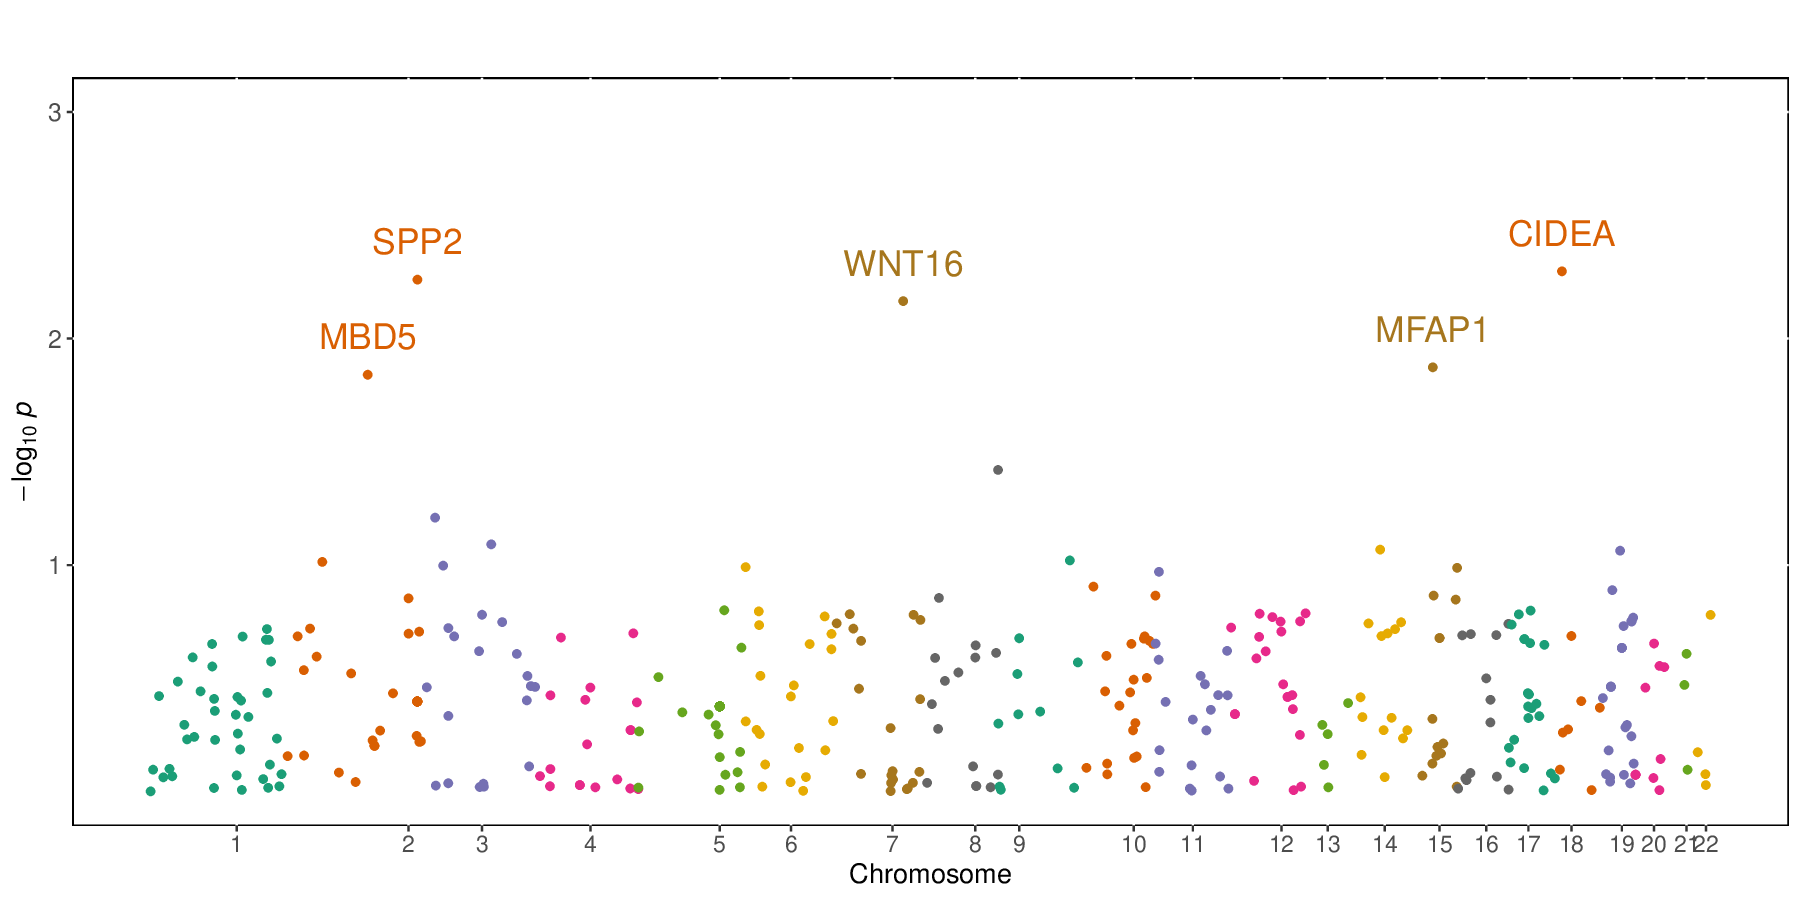

In [67]:
%preview MHRV.pdf -s png --dpi 150

> QQRV.pdf (7.6 KiB):

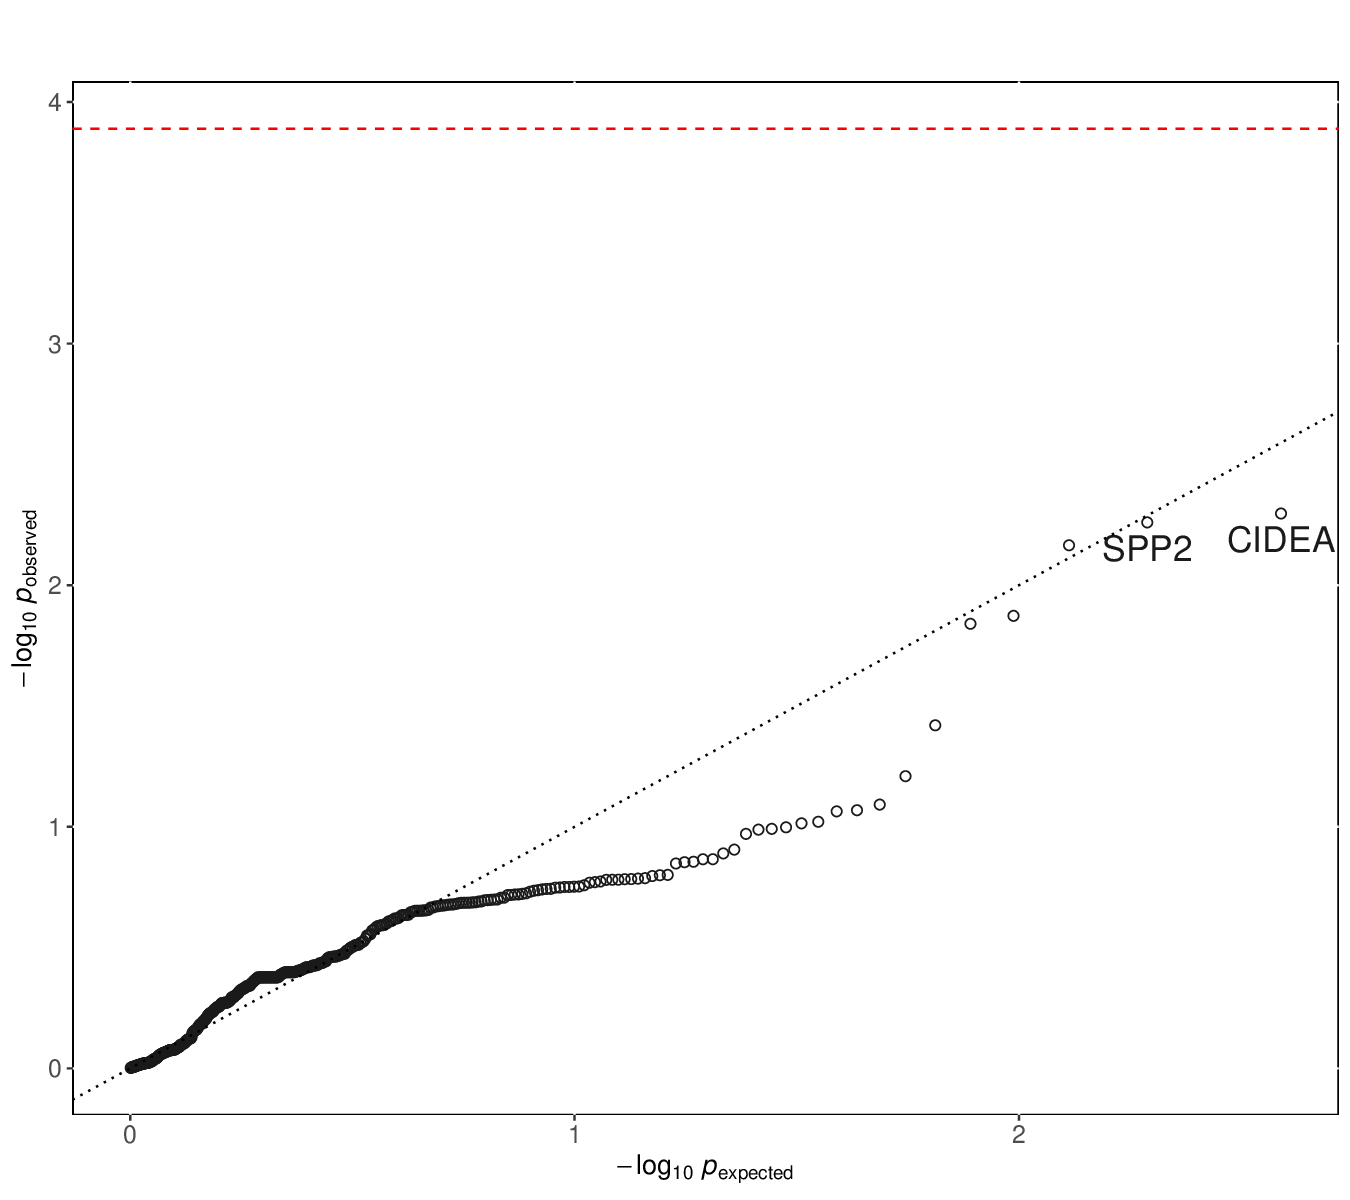

In [68]:
%preview QQRV.pdf -s png --dpi 150

QQ plots aid in evaluating if there is systematic inflation of test statistics. A common cause of inflation is population structure or batch effects.  If you observe significant inflation of test you may consider including MDS components in the association test model.

### MDS analysis and PC adjustment

This pipeline needs [PLINK 1.9](https://www.cog-genomics.org/plink/1.9/)
and [KING](http://people.virginia.edu/~wc9c/KING/executables/Linux-king224.tar.gz).

In [69]:
vtools execute KING

INFO: Executing KING.king_0: Load specified snapshot if a snapshot is specified. Otherwise use the existing project.
INFO: Executing KING.king_10: Check the existence of KING and PLINK command.
INFO: Command king is located.
INFO: Command plink is located.
INFO: Executing KING.king_20: Write selected variant and samples in tped format
INFO: Running vtools export variant --format tped --samples "1" | awk '{$2=$1"_"$4;$3=0;print $0}' > /home/jovyan/work/.vtools_cache/KING.tped
INFO: Executing KING.king_21: Rename tfam file to match tped file
INFO: Running mv variant.tfam /home/jovyan/work/.vtools_cache/KING.tfam
INFO: Executing KING.king_30: Calculate LD pruning candidate list with a cutoff of R^2=0.5
INFO: Running plink --tped KING.tped --tfam KING.tfam --indep-pairwise 50 5 0.5 --allow-no-sex --out KING.LD.50 under /home/jovyan/work/.vtools_cache
INFO: Executing KING.king_31: LD pruning from pre-calculated list
INFO: Running plink --tped KING.tped --tfam KING.tfam --extract KING.LD.50.

> KING.mds.pdf (6.1 KiB):

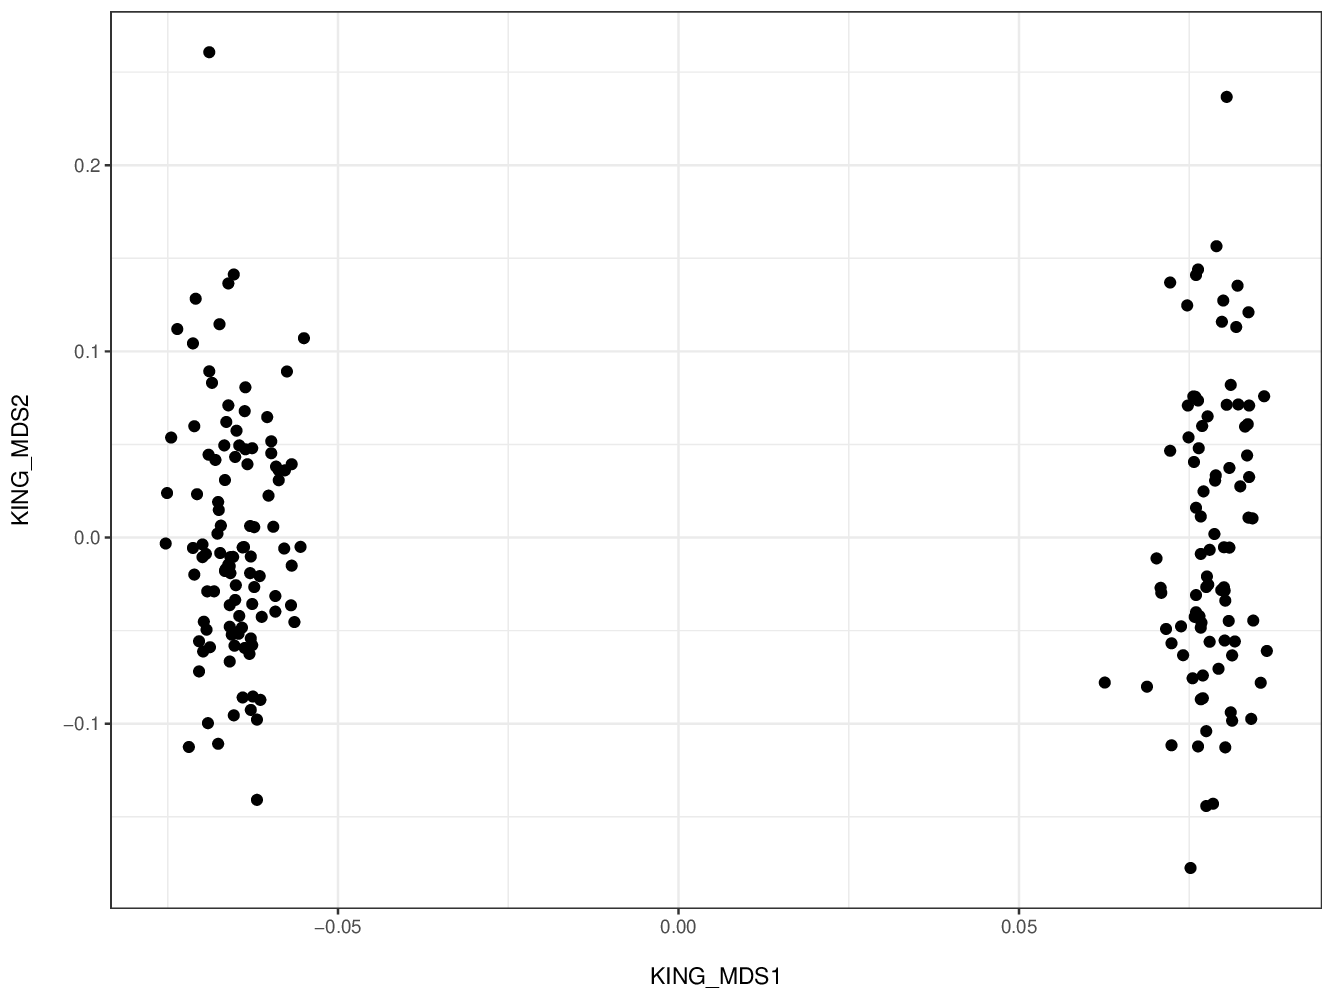

In [70]:
%preview KING.mds.pdf -s png --dpi 150

You should not arbitrarily include MDS (or PCA) components in the analysis.  Instead put in each MDS component and examine the lambda value, i.e. include MDS component 1 them MDS components 1 and 2, etc. Visualization of the QQ plot is also useful to determine if population substructure/admixture is controlled.

## Association analysis of YRI samples

Procedures for YRI sample association analysis is the same as for CEU samples as previously has been described, thus is left as an extra exercise for you to work on your own. Commands to perform analysis for YRI are found below:

In [71]:
vtools associate rare_ceu BMI --covariate SEX KING_MDS1 KING_MDS2 -m "LinRegBurden --name RVMDS2 --alternative 2" -g refGene.name2 -j1 --to_db EA_RV > EA_RV_MDS2.asso.res

INFO: 196 samples are found
INFO: 400 groups are found
/opt/conda/lib/python3.7/site-packages/tables/leaf.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  key = numpy.array(key)
Testing for association: 100% [=======================] 400/5 82.1/s in 00:00:04
INFO: Association tests on 400 groups have completed. 5 failed.
INFO: Using annotation DB EA_RV as EA_RV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:47:41
INFO: 400 out of 23269 refGene.refGene.name2 are annotated through annotation database EA_RV


In [72]:
vtools_report plot_association qq -o QQRV_MDS2 -b --label_top 2 -f 6 < EA_RV_MDS2.asso.res

INFO: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
INFO: Reading from standard input ...
INFO: Processing 98K of input data ...
INFO: Generating graph(s) ...
Genomic inflation factor for method 'RVMDS2' is: 1.18113635349461
INFO: Complete!


In [73]:
vtools select variant "YRI_mafGD10>=0.05" --samples "RACE=0" -t common_yri 

Running: 9 405.7/s in 00:00:00                                                  
INFO: 1984 variants selected.


In [74]:
vtools select v_funct "YRI_mafGD10<0.01" --samples "RACE=0" -t rare_yri

Running: 7 368.9/s in 00:00:00                                                  
INFO: 721 variants selected.


In [75]:
vtools associate common_yri BMI --covariate SEX --samples "RACE=0" -m "LinRegBurden --alternative 2" -j1 --to_db YA_CV > YA_CV.asso.res

INFO: 112 samples are selected by condition: (RACE=0)
INFO: 1984 groups are found
Testing for association: 100% [===================] 1,984/12 157.1/s in 00:00:12
INFO: Association tests on 1984 groups have completed. 12 failed.
INFO: Using annotation DB YA_CV as YA_CV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:48:45
INFO: 1984 out of 6986 variant.chr, variant.pos are annotated through annotation database YA_CV


In [76]:
vtools associate rare_yri BMI --covariate SEX --samples "RACE=0" -m "LinRegBurden --alternative 2" -g refGene.name2 -j1 --to_db YA_RV > YA_RV.asso.res 

INFO: 112 samples are selected by condition: (RACE=0)
INFO: 405 groups are found
/opt/conda/lib/python3.7/site-packages/tables/leaf.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  key = numpy.array(key)
Testing for association: 100% [====================] 405/234 153.4/s in 00:00:02
INFO: Association tests on 405 groups have completed. 234 failed.
INFO: Using annotation DB YA_RV as YA_RV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:49:06
INFO: 405 out of 23269 refGene.refGene.name2 are annotated through annotation database YA_RV


In [77]:
vtools associate rare_yri BMI --covariate SEX --samples "RACE=0" -m "VariableThresholdsQt --alternative 2 -p 100000 --adaptive 0.0005" \
    -g refGene.name2 -j1 --to_db YA_RV > YA_RV_VT.asso.res

INFO: 112 samples are selected by condition: (RACE=0)
INFO: 405 groups are found
Testing for association: 100% [=====================] 405/234 59.8/s in 00:00:06
INFO: Association tests on 405 groups have completed. 234 failed.
INFO: Using annotation DB YA_RV as YA_RV in project VATDemo.
INFO: Annotation database used to record results of association tests. Created on Mon, 25 Jan 2021 20:49:06
INFO: 405 out of 23269 refGene.refGene.name2 are annotated through annotation database YA_RV


## Meta-analysis

Here we demonstrate the application of meta-analysis to combine association results from the two populations via `vtools report meta_analysis`. More details about `vtools report meta_analysis` command can be found at 

http://varianttools.sourceforge.net/VtoolsReport/MetaAnalysis

The input to this command are the association results files generated from previous steps, for example:

In [78]:
vtools_report meta_analysis EA_RV_VT.asso.res YA_RV_VT.asso.res --beta 5 --pval 6 --se 7 -n 2 --link 1 > META_RV_VT.asso.res

INFO: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


To view the results,

In [79]:
cut -f1,3 META_RV_VT.asso.res | sort -g -k2 | head

refgene_name2	pvalue_meta
POLE	9.123E-02
SLC22A14	4.373E-01
PSMB8	4.981E-01
MORC1	8.425E-01


Note that for genes that only appears in one study but not the other, or only have a valid p-value in one study but not the other, will be ignored from meta-analysis.

## Summary

Analyzing variants with VAT is much like any other analysis software with a general workflow of:

- Variant level cleaning
- Sample genotype cleaning
- Variant annotation and phenotype information processing
- Sample/variant selection
- Association analysis
- Interpreting the findings

The data cleaning and filtering conditions within this exercise should be considered as general guidelines. Your data may allow you to be laxer with certain criteria or force you to be more stringent with others.

## Questions

### Question 1 

List the four lowest p-values and associated variants or gene regions for the EA `CV.asso.res`, `EA RV.asso.res`, and `EA RV VT.asso.res` test outputs, which are results from single variant Wald test, rare variant BRV and VT tests, respectively, using the European American (CEU) population. Also, list the results using Yoruba African (YRI) population from `YA CV.asso.res`, `YA RV.asso.res` and `YA RV VT.asso.res`.

EA CV.asso.res - single variant tests using CEU

1)

2)

3)

4)


EA RV.asso.res - BRV tests using CEU

1)

2)

3)

4)



EA RV VT.asso.res - VT tests using CEU


1)

2)

3)

4)



YA CV.asso.res - single variant tests using YRI


1)

2)

3)

4)



YA RV.asso.res - BRV tests using YRI


1)

2)

3)

4)



YA RV VT.asso.res - VT tests using YRI


1)

2)

3)

4)

### Question 2 

List any gene regions that show up in the lowest eight p-values for both the BRV and the VT tests. Why might the p-values for the VT tests be higher than the p-values for the BRV tests? Are any of the top p-value hits significant? Why or why not?

## Answers

### Question 1

EA CV.asso.res
1. 107888886 0.000105185
2. 15869257 0.00038548
3. 56293401 0.000386273
4. 15869388 0.00279873

EA RV.asso.res
1. CIDEA 0.00504822
2. UGT1A10 0.00549521
3. UGT1A5 0.00549521
4. UGT1A6 0.00549521

EA RV VT.asso.res
1. UGT1A9 0.007996
2. CPED1 0.00999001
3. UGT1A10 0.00999001
4. UGT1A6 0.011988

YA CV.asso.res

1. 107888886 0.00000974
2. 6003506 0.000211457
3. 25901623 0.001329
4. 3392651 0.00194995

YA RV.asso.res

1. EMILIN2 0.00262487
2. ASIC2 0.0551664
3. MDN1 0.0593085
4. BAZ2B 0.0607625

YA RV VT.asso.res

1. EMILIN2 0.00533156
2. MDN1 0.013986
3. VLDLR 0.01998
4. LRRC9 0.025974

### Question 2

The p-values do not achieve significance based on the corrected p values above (Bonferroni correction for multiple tests). Since the BMI values were randomly generated for each individual it is unlikely that any of the p-values for the single variant and aggregation tests would have achieved significance. Also, because of the multiple testing, the p-values for the VT tests might be higher than the p-values for the BRV tests.

## References

1.  Wang, G.T., Peng, B., and Leal, S.M. (2014). Variant Association
    Tools for Quality Control and Analysis of Large-Scale Sequence and
    Genotyping Array Data. Am. J. Hum. Genet. 94, 770783


2.  Li B, Leal SM. Methods for
    detecting associations with rare variants for common diseases:
    application to analysis of sequence data. Am J Hum Genet 2008
    83:311-21

3.  Auer PL, Wang G, Leal SM. Testing for rare variant associations in
    the presence of missing data. Genet Epidemiol 2013 37:529-38

4.  Liu DJ, Leal SM. A novel adaptive method for the analysis of
    next-generation sequencing data to detect com-plex trait
    associations with rare variants due to gene main effects
    and interactions. PLoS Genet 2010 6:e1001156

5.  Madsen BE, Browning SR. A groupwise association test for rare
    mutations using a weighted sum statistic. PLoS Genet 2009 5:e1000384

6.  Price AL, Kryukov GV, de Bakker PI, Purcell SM, Staples J, Wei LJ,
    Sunyaev SR. Pooled association tests for rare variants in
    exon-resequencing studies. Am J Hum Genet 20010 86:832-8

7.  Wu MC, Lee S, Cai T, Li Y, Boehnke M, Lin X. Rare-variant
    association testing for sequencing data with the sequence kernel
    association test. Am J Hum Genet 2011 89:82-93

8.  Lucas FAS, Wang G, Scheet P, Peng B. Integrated annotation and
    analysis of genetic variants from next-generation sequencing studies
    with variant tools. Bioinformatics 2012 28:421-2

9.  Wang K, Li M, Hakonarson H. ANNOVAR: functional annotation of
    genetic variants from high-throughput sequencing data. Nucleic Acids
    Res 2010 38:e164

10. Manichaikul A, Mychaleckyj JC, Rich SS, Daly K, Sale M, Chen WM.
    Robust relationship inference in genome-wide association studies.
    Bioinformatics 2010 26(22):2867-2873

11. Purcell S, Neale B, Todd-Brown K, Thomas L, Ferreira MAR, Bender D,
    Maller J, Sklar P, de Bakker PIW, Daly MJ & Sham PC. PLINK: a
    toolset for whole-genome association and population-based
    linkage analysis. Am J Hum Genet, 2007 81:559-75